```
Описание проекта
Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.
```

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st

## Чтение и подготовка данных

In [2]:
calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv', index_col=0)
messages = pd.read_csv('/datasets/messages.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
users = pd.read_csv('/datasets/users.csv')

### Тарифы

---
```
Описание тарифов

Тариф «Смарт»
Ежемесячная плата: 550 рублей
Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
Стоимость услуг сверх тарифного пакета:
1. минута разговора: 3 рубля («Мегалайн» всегда округляет вверх значения минут и мегабайтов. 
   Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута); 
2. сообщение: 3 рубля; 
3. 1 Гб интернет-трафика: 200 рублей.

Тариф «Ультра»
Ежемесячная плата: 1950 рублей
Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
Стоимость услуг сверх тарифного пакета: 
1. минута разговора: 1 рубль; 
2. сообщение: 1 рубль; 
3. 1 Гб интернет-трафика: 150 рублей.

Примечание:
«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. 
Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.
Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. 
Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.
```

```
Таблица tariffs (информация о тарифах):
tariff_name — название тарифа
rub_monthly_fee — ежемесячная абонентская плата в рублях
minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
messages_included — количество сообщений в месяц, включённых в абонентскую плату
mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
rub_per_message — стоимость отправки сообщения сверх тарифного пакета
rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)
```

In [3]:
tariffs.info()
print('------------------------------------------------------------------')
tariffs.messages_included = tariffs.messages_included.astype('uint16')
tariffs.mb_per_month_included = tariffs.mb_per_month_included.astype('uint32')
tariffs.minutes_included = tariffs.minutes_included.astype('uint16')
tariffs.rub_monthly_fee = tariffs.rub_monthly_fee.astype('uint16')
tariffs.rub_per_gb = tariffs.rub_per_gb.astype('uint16')
tariffs.rub_per_message = tariffs.rub_per_message.astype('uint8')
tariffs.rub_per_minute = tariffs.rub_per_minute.astype('uint8')
tariffs.info()
print('------------------------------------------------------------------')
tariffs.T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes
------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null uint16
mb_per_month_included    2 non-null uint32
minutes_included         2 non-null uint16
rub_monthly_fee          2 non-null uint16
rub_per_gb               2 non-null uint16
rub_per_message          2 non-null uint8
rub_per_minute           2 non-null uint8
tariff_name              2 non-null object

,0,1
messages_included,50,1000
mb_per_month_included,15360,30720
minutes_included,500,3000
rub_monthly_fee,550,1950
rub_per_gb,200,150
rub_per_message,3,1
rub_per_minute,3,1
tariff_name,smart,ultra


### Пользователи

```
Таблица users (информация о пользователях):
user_id — уникальный идентификатор пользователя
first_name — имя пользователя
last_name — фамилия пользователя
age — возраст пользователя (годы)
reg_date — дата подключения тарифа (день, месяц, год)
churn_date — дата прекращения пользования тарифом (если значение пропущено, 
то тариф ещё действовал на момент выгрузки данных)
city — город проживания пользователя
tarif — название тарифного плана

```

In [4]:
users.info()
print('------------------------------------------------------------------')
users.user_id = users.user_id.astype('uint16')
users.age = users.age.astype('uint8')
users.churn_date = pd.to_datetime(users.churn_date, format='%Y-%m-%d')
users.reg_date = pd.to_datetime(users.reg_date, format='%Y-%m-%d')
users['tariff_id'] = 0
users.tariff_id = (users.tariff_id.where(users.tariff=='smart', 1)).astype('uint8')
users.info()
print('------------------------------------------------------------------')
print('Дубликатов строк:', users.duplicated().sum())
users

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB
------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
user_id       500 non-null uint16
age           500 non-null uint8
churn_date    38 non-null datetime64[ns]
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null datetime64[ns]
tariff        500 non-null object
tariff_id     500 non-null uint8
dtypes: datetime64[ns](2), object(4), uint16(1), uint8(2)
memory usage: 25.5+ KB
-----

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,tariff_id
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1
1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart,0
2,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,0
3,1003,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra,1
4,1004,68,NaT,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra,1
...,...,...,...,...,...,...,...,...,...
495,1495,65,NaT,Иркутск,Авксентий,Фокин,2018-08-28,ultra,1
496,1496,36,NaT,Вологда,Трифон,Блохин,2018-01-27,smart,0
497,1497,32,NaT,Челябинск,Каролина,Агеева,2018-10-09,smart,0
498,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart,0


### Звонки

```
Таблица calls (информация о звонках):
id — уникальный номер звонка
call_date — дата звонка
duration — длительность звонка в минутах
user_id — идентификатор пользователя, сделавшего звонок
```

In [5]:
calls.info()
print('------------------------------------------------------------------')
calls.call_date = pd.to_datetime(calls.call_date, format='%Y-%m-%d')
calls['month'] = calls.call_date.astype('datetime64[M]') #(calls.call_date.dt.month).astype('uint8')
calls.user_id = calls.user_id.astype('uint16')
calls.duration = (calls.duration.apply(np.ceil)).astype('uint16')
calls.info()
print('------------------------------------------------------------------')
print('Дубликатов строк:', calls.duplicated().sum())
calls

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB
------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 5 columns):
id           202607 non-null object
call_date    202607 non-null datetime64[ns]
duration     202607 non-null uint16
user_id      202607 non-null uint16
month        202607 non-null datetime64[ns]
dtypes: datetime64[ns](2), object(1), uint16(2)
memory usage: 5.4+ MB
------------------------------------------------------------------
Дубликатов строк: 0


,id,call_date,duration,user_id,month
0,1000_0,2018-07-25,0,1000,2018-07-01
1,1000_1,2018-08-17,0,1000,2018-08-01
2,1000_2,2018-06-11,3,1000,2018-06-01
3,1000_3,2018-09-21,14,1000,2018-09-01
4,1000_4,2018-12-15,6,1000,2018-12-01
...,...,...,...,...,...
202602,1499_215,2018-12-26,1,1499,2018-12-01
202603,1499_216,2018-10-18,19,1499,2018-10-01
202604,1499_217,2018-11-10,11,1499,2018-11-01
202605,1499_218,2018-10-06,5,1499,2018-10-01


### Интернет

```
Таблица internet (информация об интернет-сессиях):
id — уникальный номер сессии
mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
session_date — дата интернет-сессии
user_id — идентификатор пользователя
```

In [6]:
internet.info()
print('------------------------------------------------------------------')
internet.session_date = pd.to_datetime(internet.session_date, format='%Y-%m-%d')
internet['month'] = internet.session_date.astype('datetime64[M]') #(internet.session_date.dt.month).astype('uint8')
internet.user_id = internet.user_id.astype('uint16')
internet.info()
print('------------------------------------------------------------------')
print('Дубликатов строк:', internet.duplicated().sum())
internet

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 5.7+ MB
------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 5 columns):
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null datetime64[ns]
user_id         149396 non-null uint16
month           149396 non-null datetime64[ns]
dtypes: datetime64[ns](2), float64(1), object(1), uint16(1)
memory usage: 6.0+ MB
------------------------------------------------------------------
Дубликатов строк: 0


,id,mb_used,session_date,user_id,month
0,1000_0,112.95,2018-11-25,1000,2018-11-01
1,1000_1,1052.81,2018-09-07,1000,2018-09-01
2,1000_2,1197.26,2018-06-25,1000,2018-06-01
3,1000_3,550.27,2018-08-22,1000,2018-08-01
4,1000_4,302.56,2018-09-24,1000,2018-09-01
...,...,...,...,...,...
149391,1499_152,318.90,2018-10-03,1499,2018-10-01
149392,1499_153,490.13,2018-12-14,1499,2018-12-01
149393,1499_154,0.00,2018-10-27,1499,2018-10-01
149394,1499_155,1246.32,2018-11-26,1499,2018-11-01


### Сообщения

```
Таблица messages (информация о сообщениях):
id — уникальный номер сообщения
message_date — дата сообщения
user_id — идентификатор пользователя, отправившего сообщение
```

In [7]:
messages.info()
print('------------------------------------------------------------------')
messages.message_date = pd.to_datetime(messages.message_date, format='%Y-%m-%d')
messages['month'] =  messages.message_date.astype('datetime64[M]') #(messages.message_date.dt.month).astype('uint8')
messages.user_id = messages.user_id.astype('uint16')
messages.info()
print('------------------------------------------------------------------')
print('Дубликатов строк:', messages.duplicated().sum())
messages

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB
------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 4 columns):
id              123036 non-null object
message_date    123036 non-null datetime64[ns]
user_id         123036 non-null uint16
month           123036 non-null datetime64[ns]
dtypes: datetime64[ns](2), object(1), uint16(1)
memory usage: 3.1+ MB
------------------------------------------------------------------
Дубликатов строк: 0


,id,message_date,user_id,month
0,1000_0,2018-06-27,1000,2018-06-01
1,1000_1,2018-10-08,1000,2018-10-01
2,1000_2,2018-08-04,1000,2018-08-01
3,1000_3,2018-06-16,1000,2018-06-01
4,1000_4,2018-12-05,1000,2018-12-01
...,...,...,...,...
123031,1499_179,2018-12-12,1499,2018-12-01
123032,1499_180,2018-09-28,1499,2018-09-01
123033,1499_181,2018-09-27,1499,2018-09-01
123034,1499_182,2018-11-15,1499,2018-11-01


### Вывод

```
Исходные данные хорошего качества, пропусков нет, дубликатов строк нет.
Типы данных были приведены в соответствие с содержимым столбцов.
Время разговоров округлено до минут вверх согласно политикой ОПСОС
В таблицы calls, internet, messages  добавлены столбцы month для 
дальнейшей группировки и объединения таблиц.
Также в таблицу users добавлен столбец tariff_id как числовой идентификатор тарифа
```

## Расчет потребления  услуг пользователями по месяцам:

### Количество и суммарная продолжительность звонков:

In [8]:
calls_pvt = calls.pivot_table(index=['user_id', 'month'], values='duration', aggfunc = ['count', 'sum'])
calls_pvt.columns = ['calls_qnt', 'calls_duration']
calls_pvt

calls_qnt  calls_duration
user_id month                                
1000    2018-05-01         22             159
        2018-06-01         43             172
        2018-07-01         47             340
        2018-08-01         52             408
        2018-09-01         58             466
...                       ...             ...
1498    2018-10-01         41             247
1499    2018-09-01          9              70
        2018-10-01         68             449
        2018-11-01         74             612
        2018-12-01         69             492

[3174 rows x 2 columns]

### Интернет-трафик:

In [9]:
internet_pvt = internet.pivot_table(index=['user_id', 'month'], aggfunc = 'sum')
internet_pvt['gb_used'] = internet_pvt['mb_used'] / 1024
internet_pvt.gb_used = (internet_pvt.gb_used.apply(np.ceil)).astype('uint16')
internet_pvt

mb_used  gb_used
user_id month                        
1000    2018-05-01   2253.49        3
        2018-06-01  23233.77       23
        2018-07-01  14003.64       14
        2018-08-01  14055.93       14
        2018-09-01  14568.91       15
...                      ...      ...
1498    2018-10-01  20579.36       21
1499    2018-09-01   1845.75        2
        2018-10-01  17788.51       18
        2018-11-01  17963.31       18
        2018-12-01  13055.58       13

[3203 rows x 2 columns]

### СМС:

In [10]:
messages_pvt = messages.pivot_table(index=['user_id', 'month'], values='id', aggfunc='count')
messages_pvt.columns = ['messages']
messages_pvt

messages
user_id month               
1000    2018-05-01        22
        2018-06-01        60
        2018-07-01        75
        2018-08-01        81
        2018-09-01        57
...                      ...
1498    2018-10-01        42
1499    2018-09-01        11
        2018-10-01        48
        2018-11-01        59
        2018-12-01        66

[2717 rows x 1 columns]

### Сводная таблица по всем услугам:

In [11]:
pvt = calls_pvt.join([internet_pvt.gb_used, messages_pvt], 
                     how='outer').fillna(0)

pvt.calls_qnt = pvt.calls_qnt.astype('uint16')
pvt.calls_duration = pvt.calls_duration.astype('uint16')
pvt.gb_used = pvt.gb_used.astype('uint16')
pvt.messages = pvt.messages.astype('uint16')

users_tariff = users.pivot_table(index = 'user_id', 
                                 values=['tariff_id', 'city'],
                                 aggfunc='first')
pvt = pvt.join(users_tariff)
pvt = pvt.join(tariffs, on='tariff_id')

pvt.info()
pvt

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3214 entries, (1000, 2018-05-01 00:00:00) to (1499, 2018-12-01 00:00:00)
Data columns (total 14 columns):
calls_qnt                3214 non-null uint16
calls_duration           3214 non-null uint16
gb_used                  3214 non-null uint16
messages                 3214 non-null uint16
city                     3214 non-null object
tariff_id                3214 non-null uint8
messages_included        3214 non-null uint16
mb_per_month_included    3214 non-null uint32
minutes_included         3214 non-null uint16
rub_monthly_fee          3214 non-null uint16
rub_per_gb               3214 non-null uint16
rub_per_message          3214 non-null uint8
rub_per_minute           3214 non-null uint8
tariff_name              3214 non-null object
dtypes: object(2), uint16(8), uint32(1), uint8(3)
memory usage: 135.9+ KB


calls_qnt  calls_duration  gb_used  messages         city  \
user_id month                                                                   
1000    2018-05-01         22             159        3        22    Краснодар   
        2018-06-01         43             172       23        60    Краснодар   
        2018-07-01         47             340       14        75    Краснодар   
        2018-08-01         52             408       14        81    Краснодар   
        2018-09-01         58             466       15        57    Краснодар   
...                       ...             ...      ...       ...          ...   
1498    2018-10-01         41             247       21        42  Владикавказ   
1499    2018-09-01          9              70        2        11        Пермь   
        2018-10-01         68             449       18        48        Пермь   
        2018-11-01         74             612       18        59        Пермь   
        2018-12-01         69             492       13        66        Пермь   

                    tariff_id  messages_included  mb_per_month_included  \
user_id month                                                             
1000    2018-05-01          1               1000                  30720   
        2018-06-01          1               1000                  30720   
        2018-07-01          1               1000                  30720   
        2018-08-01          1               1000                  30720   
        2018-09-01          1               1000                  30720   
...                       ...                ...                    ...   
1498    2018-10-01          0                 50                  15360   
1499    2018-09-01          0                 50                  15360   
        2018-10-01          0                 50                  15360   
        2018-11-01          0                 50                  15360   
        2018-12-01          0                 50                  15360   

                    minutes_included  rub_monthly_fee  rub_per_gb  \
user_id month                                                       
1000    2018-05-01              3000             1950         150   
        2018-06-01              3000             1950         150   
        2018-07-01              3000             1950         150   
        2018-08-01              3000             1950         150   
        2018-09-01              3000             1950         150   
...                              ...              ...         ...   
1498    2018-10-01               500              550         200   
1499    2018-09-01               500              550         200   
        2018-10-01               500              550         200   
        2018-11-01               500              550         200   
        2018-12-01               500              550         200   

                    rub_per_message  rub_per_minute tariff_name  
user_id month                                                    
1000    2018-05-01                1               1       ultra  
        2018-06-01                1               1       ultra  
        2018-07-01                1               1       ultra  
        2018-08-01                1               1       ultra  
        2018-09-01                1               1       ultra  
...                             ...             ...         ...  
1498    2018-10-01                3               3       smart  
1499    2018-09-01                3               3       smart  
        2018-10-01                3               3       smart  
        2018-11-01                3               3       smart  
        2018-12-01                3               3       smart  

[3214 rows x 14 columns]

### Удаление неполных месяцев:

Удалим из таблицы месяцы регистрации пользователей, если регистрация была после 10 числа,  
и месяцы прекращения договора, если это произошло до 20 числа соответствующего месяца.   
Таким образом исключим из расчетов месяцы, использованные менее чем на $2/3$

In [13]:
len_before = len(pvt)

In [14]:
incomplete_reg_months = (users.reg_date.dt.day > 10) 
incomplete_churn_months = (users.churn_date.dt.day < 20)

user_id = list(users[incomplete_reg_months].user_id)
month = list(users[incomplete_reg_months].reg_date.dt.month)
drop_list = [ (i, m) for i, m in zip(user_id, month) ]
pvt.drop(drop_list, errors='ignore', inplace=True)

user_id = list(users[incomplete_churn_months].user_id)
month = list(users[incomplete_churn_months].reg_date.dt.month)
drop_list = [ (i, m) for i, m in zip(user_id, month) ]
pvt.drop(drop_list, errors='ignore', inplace=True)

In [15]:
print('Размер таблицы до удаления:', len_before)
print('Размер таблицы после удаления:', len(pvt))

Размер таблицы до удаления: 3214
Размер таблицы после удаления: 3214


### Расчет расходов пользователей на услуги связи:

согласно действующим тарифам

In [16]:
pvt['expences'] = pvt.rub_monthly_fee

pvt.expences = pvt.expences.where(pvt.calls_duration<=pvt.minutes_included, pvt.expences +
                   (pvt.calls_duration-pvt.minutes_included)*pvt.rub_per_minute
                  )

pvt.expences = pvt.expences.where(pvt.gb_used<=pvt.mb_per_month_included//1024, pvt.expences +
                   (pvt.gb_used-pvt.mb_per_month_included//1024)*pvt.rub_per_gb
                  )

pvt.expences = pvt.expences.where(pvt.messages<=pvt.messages_included, pvt.expences +
                   (pvt.messages-pvt.messages_included)*pvt.rub_per_message
                  )

### Вывод

Таблица pvt содержит все данные, необходимые для дальнейшей работы  
сгруппированные по пользователям и месяцам.

## Анализ данных

### Сравнение тарифов:

сделаем случайную выборку одинакового количества записей для каждого тарифа

In [17]:
tariff_smart_smp = pvt.query('tariff_name=="smart"').sample(n=500)
tariff_ultra_smp = pvt.query('tariff_name=="ultra"').sample(n=500)

и рассмотрим интересующие значения

In [18]:
cols = ['calls_duration', 'gb_used', 'messages', 'expences']
smart_des = tariff_smart_smp[cols].describe()
ultra_des = tariff_ultra_smp[cols].describe()
smart_des.columns = pd.MultiIndex.from_tuples( [(x, y) for x, y in zip(['smart']*10, cols)] )
ultra_des.columns = pd.MultiIndex.from_tuples( [(x, y) for x, y in zip(['ultra']*10, cols)] )
smart_des.join(ultra_des).T.round(2)

count     mean     std     min      25%     50%  \
smart calls_duration  500.0   437.86  193.28     7.0   305.50   440.5   
      gb_used         500.0    16.66    5.65     1.0    13.00    17.0   
      messages        500.0    35.31   28.51     0.0    12.00    31.0   
      expences        500.0  1345.48  860.62   550.0   583.00  1148.0   
ultra calls_duration  500.0   540.96  319.52     0.0   293.25   535.0   
      gb_used         500.0    19.73   10.24     0.0    12.00    20.0   
      messages        500.0    49.69   47.77     0.0     5.00    40.0   
      expences        500.0  2094.90  432.91  1950.0  1950.00  1950.0   

                          75%     max  
smart calls_duration   567.75  1022.0  
      gb_used           20.00    38.0  
      messages          55.00   143.0  
      expences        1818.25  6770.0  
ultra calls_duration   779.25  1609.0  
      gb_used           27.00    49.0  
      messages          79.00   223.0  
      expences        1950.00  4800.0

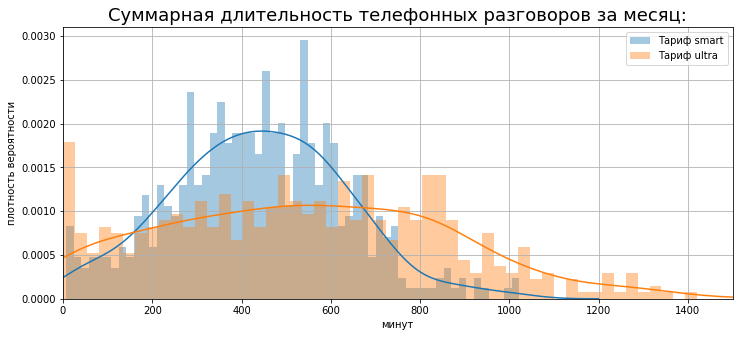

In [19]:
plt.figure(figsize=(12, 5))
ax = sns.distplot( a=tariff_smart_smp.calls_duration, hist=True, kde=True, rug=False, label='Тариф smart', bins=60)
ax = sns.distplot( a=tariff_ultra_smp.calls_duration, hist=True, kde=True, rug=False, label='Тариф ultra', bins=60)
ax.legend(); plt.grid()
plt.title('Суммарная длительность телефонных разговоров за месяц:', fontdict={'size':18})
plt.xlabel('минут'); plt.ylabel('плотность вероятности')
plt.xlim(0, 1500) 
plt.show()

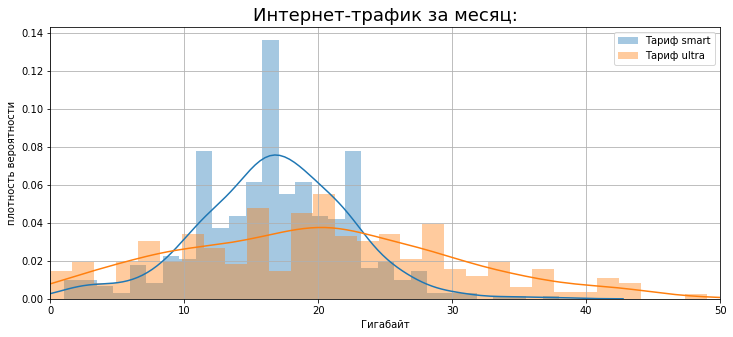

In [20]:
plt.figure(figsize=(12, 5))
ax = sns.distplot( a=tariff_smart_smp.gb_used, hist=True, kde=True, rug=False, label='Тариф smart', bins=30)
ax = sns.distplot( a=tariff_ultra_smp.gb_used, hist=True, kde=True, rug=False, label='Тариф ultra', bins=30)
ax.legend(); plt.grid()
plt.title('Интернет-трафик за месяц:', fontdict={'size':18}) 
plt.xlabel('Гигабайт'); plt.ylabel('плотность вероятности')
plt.xlim(0, 50)
plt.show()

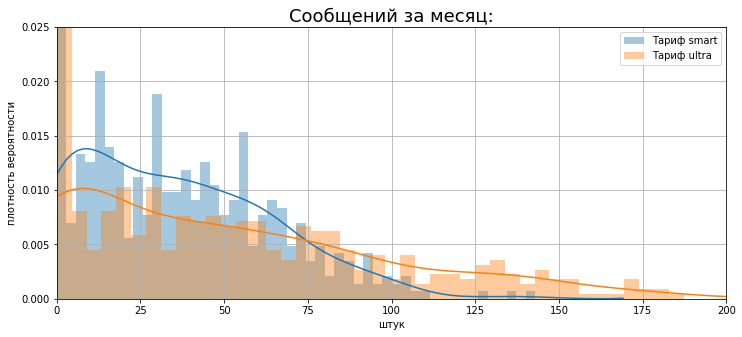

In [21]:
plt.figure(figsize=(12, 5))
ax = sns.distplot( a=tariff_smart_smp.messages, hist=True, kde=True, rug=False, label='Тариф smart', bins=50 )
ax = sns.distplot( a=tariff_ultra_smp.messages, hist=True, kde=True, rug=False, label='Тариф ultra', bins=50 )
ax.legend(); plt.grid()
plt.title('Сообщений за месяц:', fontdict={'size':18}) 
plt.xlabel('штук'); plt.ylabel('плотность вероятности')
plt.xlim(0, 200); plt.ylim(0, 0.025)
plt.show()

### Вывод

- Тариф "Ультра" имеет почти вдвое большее стандартное отклонение по всем параметрам за исключением стоимости услуг - по этому показателю ситуация обратная.  
- На тарифе "Ультра" средняя продолжительность разговоров больше примерно на 25%, интернет-трафик - на 18%,  количество СМС на 50% по сравнению с тарифом "Смарт"
- Оба тарифа имеют симметричное распределение длительности звонков и интернет-трафика (медиана близка к среднему значению)
- Оба тарифа имеют небольшое смещение вправо количества СМС и стоимости услуг
- На тарифе "Ультра" почти всем пользователям хватает включенных услуг; на тарифе "Смарт" ситуация противоположная.
- Средняя стоимость услуг на тарифе "Ультра" более чем на 50% превышает стоимость услуг на тарифе "Смарт"  

__Для компании выгоднее рекламировать тариф "Ультра", поскольку он приносит больше денег с меньшими отклонениями при незначительном (непропорциональном) увеличении среднего потребления услуг по сравнению с тарифом "Смарт".__


---

## Проверка гипотез

Зададим критический уровень статистической значимости $\alpha$ :

In [22]:
alpha = 0.01

если p-value окажется меньше него - отвергнем гипотезу

### Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;

__Нулевая гипотеза H₀__:  _Средняя выручка пользователей тарифов «Ультра» и «Смарт» не различается_

__Альтернативная гипотеза H₁__:  _Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается_

___


In [23]:
mean_expences_smart = pvt.query('tariff_name=="smart"').expences #.mean(level=0)
mean_expences_smart.round(2)

user_id  month     
1001     2018-11-01    1150
         2018-12-01     550
1002     2018-06-01     550
         2018-07-01    1150
         2018-08-01    1550
                       ... 
1498     2018-10-01    1750
1499     2018-09-01     550
         2018-10-01    1150
         2018-11-01    1513
         2018-12-01     598
Name: expences, Length: 2229, dtype: int64

In [24]:
mean_expences_ultra = pvt.query('tariff_name=="ultra"').expences #.mean(level=0)
mean_expences_ultra.round(2)

user_id  month     
1000     2018-05-01    1950
         2018-06-01    1950
         2018-07-01    1950
         2018-08-01    1950
         2018-09-01    1950
                       ... 
1495     2018-08-01    1950
         2018-09-01    2400
         2018-10-01    1950
         2018-11-01    3300
         2018-12-01    1950
Name: expences, Length: 985, dtype: int64

In [25]:
results = st.ttest_ind(mean_expences_smart, 
                       mean_expences_ultra, 
                       equal_var = False)

print('p-значение: ', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение:  4.2606313931076085e-250
Отвергаем нулевую гипотезу


__Вывод:__   
___Исходное предположение не опровергнуто: выручка пользователей тарифов «Ультра» и «Смарт» различаются___

---

### Средняя выручка пользователи из Москвы <br>   отличается от выручки пользователей из других регионов;

__Нулевая гипотеза H₀__:  _Средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов_

__Альтернативная гипотеза H₁__:  _Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов_

___

In [26]:
mean_expences_Moscow = pvt.query('city=="Москва"').expences #.mean(level=0)
mean_expences_Moscow.round(2)

user_id  month     
1001     2018-11-01    1150
         2018-12-01     550
1003     2018-08-01    1950
         2018-09-01    1950
         2018-10-01    1950
                       ... 
1490     2018-08-01     950
         2018-09-01     550
         2018-10-01    1750
         2018-11-01    1350
         2018-12-01     750
Name: expences, Length: 611, dtype: int64

In [27]:
mean_expences_not_Moscow = pvt.query('city!="Москва"').expences #.mean(level=0)
mean_expences_not_Moscow.round(2)

user_id  month     
1000     2018-05-01    1950
         2018-06-01    1950
         2018-07-01    1950
         2018-08-01    1950
         2018-09-01    1950
                       ... 
1498     2018-10-01    1750
1499     2018-09-01     550
         2018-10-01    1150
         2018-11-01    1513
         2018-12-01     598
Name: expences, Length: 2603, dtype: int64

In [28]:
results = st.ttest_ind(mean_expences_Moscow, 
                       mean_expences_not_Moscow, 
                       equal_var = False)
print('p-значение: ', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение:  0.5257376663729298
Не получилось отвергнуть нулевую гипотезу


__Вывод:__  
___Исходное предположение опровергнуто: выручка пользователи из Москвы
не отличается от выручки пользователей из других регионов___

---

## Общий вывод
<div class="alert alert-block alert-info">
    
- На тарифе "Ультра" средняя продолжительность разговоров больше примерно на 25%,  
    интернет-трафик - на 18%, количество СМС на 50% по сравнению с тарифом "Смарт"
<br> <br>       
- При этом средняя стоимость услуг на тарифе "Ультра"  
    более чем на 50% превышает стоимость услуг на тарифе "Смарт"
<br> <br>   
- Кроме того, стоимость услуг на тарифе "Ультра" менее подвержена колебаниям,  
    поскольку большинству пользователей хватает включенных услуг
<br> <br>     
<b>
Таким образом, для компании выгоднее рекламировать тариф "Ультра", поскольку он приносит больше денег с меньшими отклонениями при незначительном (непропорциональном) увеличении среднего потребления услуг по сравнению с тарифом "Смарт".
</b>
</div>